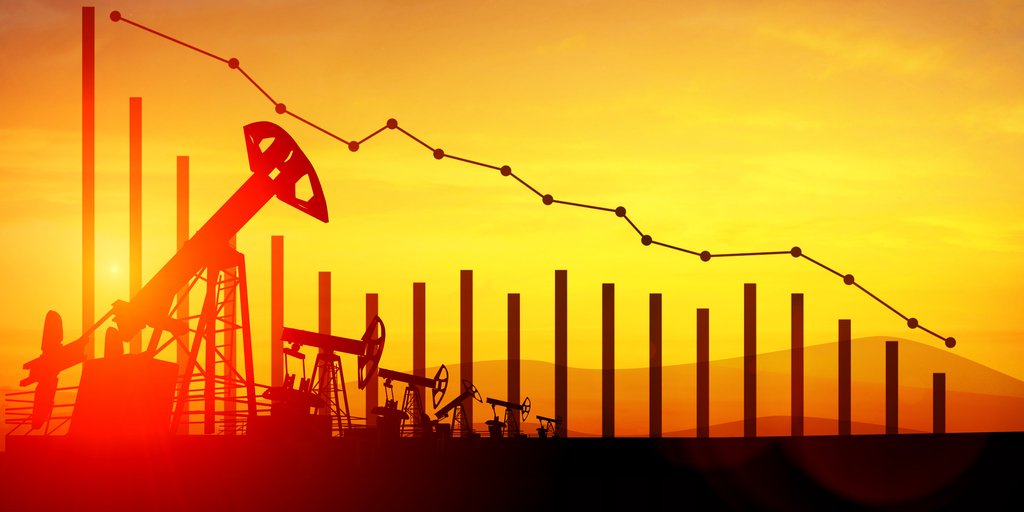
# AI-Driven Price Forecasting for Oil

We have a comprehensive dataset of worldwide crude oil prices starting from 1983, which includes both the price changes and their corresponding percentage changes over time. This historical data provides a valuable foundation for developing a forecasting solution aimed at predicting oil prices for the upcoming 18 months, enabling better demand planning and market analysis.

#1. SETUP AND REPRODUCIBILITY

In [3]:
SEED = 2147483648

import os
import random
import numpy as np
import tensorflow as tf

os.environ['PYTHONHASHSEED'] = f'{SEED}'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

#2. DATA LOADING AND EXPLORATION





                           price
date                            
1983-03-01 00:00:00+00:00  29.27
1983-04-01 00:00:00+00:00  30.63
1983-05-01 00:00:00+00:00  30.25
1983-06-01 00:00:00+00:00  31.38
1983-07-01 00:00:00+00:00  32.00


<Axes: xlabel='date'>

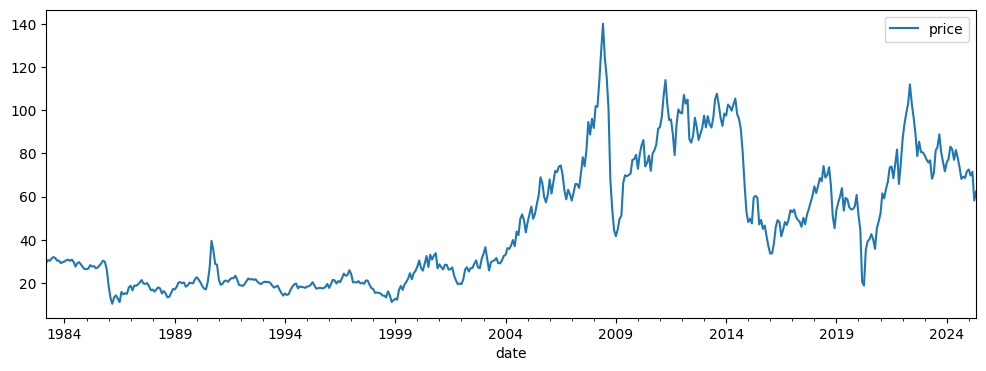

In [4]:
DATASET_PATH = 'crude-oil-price.csv'
DATE_COL = 'date'
VALUE_COL = 'price'

# DATASET_PATH = 'DZ_2002_2025_CRUDEOIL_INDPROD_KBBL.csv'
# DATE_COL = 'TIME_PERIOD'
# VALUE_COL = 'OBS_VALUE'


import pandas as pd

# Load the dataframe
df = pd.read_csv(DATASET_PATH)

# Select only the 'date' and 'price' columns
df = df[[DATE_COL, VALUE_COL]]

# Convert DATE_COL column toDATE_COLime objects
df[DATE_COL] = pd.to_datetime(df[DATE_COL])

# Set DATE_COL as the index
df = df.set_index(DATE_COL)

print(df.head())

#
for col in [VALUE_COL]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.plot(figsize=(12, 4))

#3. CHECK THE MISSING VALUES

Number of missing or invalid values:
price    0
dtype: int64


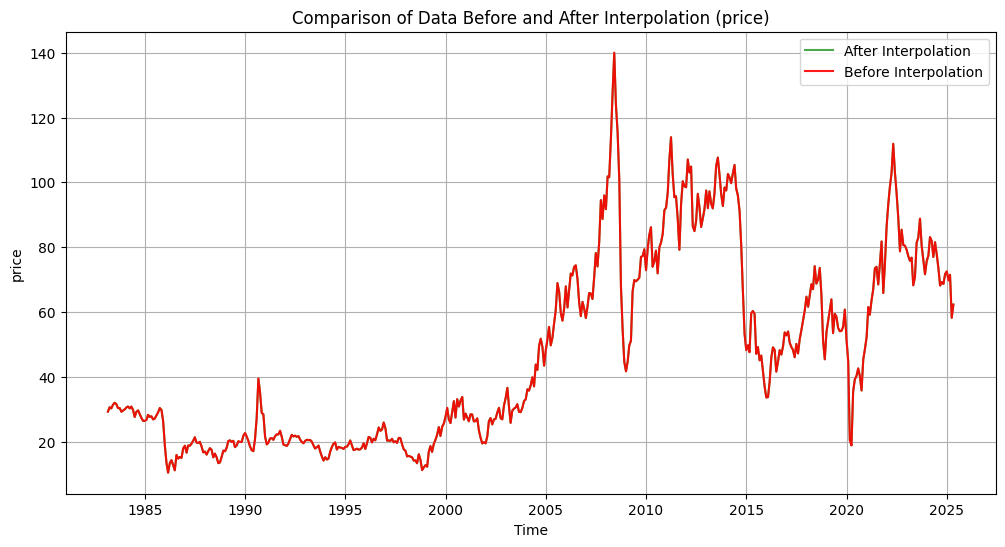

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Show the number of missing or invalid values
print("Number of missing or invalid values:")
print(df.isnull().sum())

# Replace missing or invalid values with NaN
df[VALUE_COL] = pd.to_numeric(df[VALUE_COL], errors='coerce')

# Store the original values before interpolation
original_values = df[VALUE_COL].copy()

# Interpolate missing values with respect to time
df[VALUE_COL] = df[VALUE_COL].interpolate(method='time')



# Plot the data before and after interpolation
plt.figure(figsize=(12, 6)) # Adjust figure size as needed

# Plot the interpolated values first (this will be underneath)
plt.plot(df[VALUE_COL].index, df[VALUE_COL], label='After Interpolation', marker='', linestyle='-', markersize=4, alpha=0.7, zorder=1, color='green')

# Plot the original values next (this will be on top)
plt.plot(original_values.index, original_values, label='Before Interpolation', marker='', linestyle='-', markersize=4, alpha=0.9, zorder=2, color='red')


plt.title(f'Comparison of Data Before and After Interpolation ({VALUE_COL})')
plt.xlabel('Time')
plt.ylabel(VALUE_COL)
plt.legend() # Show the legend to distinguish the lines
plt.grid(True)
plt.show()

#4. TIME SERIES DECOMPOSITION

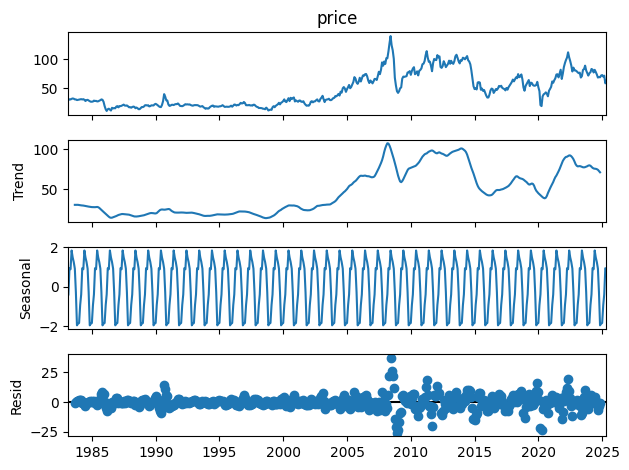

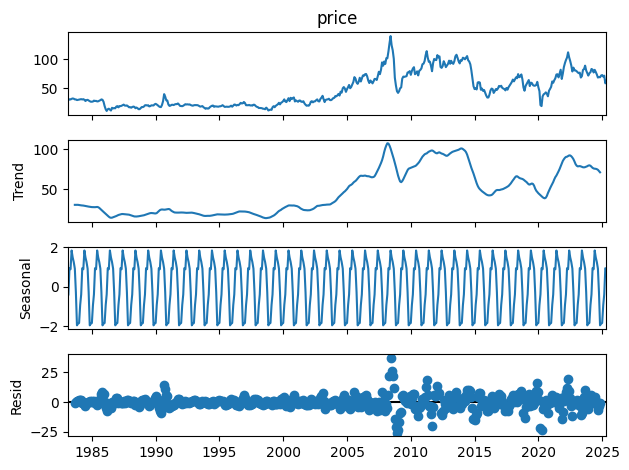

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df[VALUE_COL])
decompose.plot()

# PRE-CONFIG

In [7]:
# Dataset parameters
SEQUENCE_LENGTH = 12
PREDICTION_STEPS = 1

# Model parameters
FILTERS = 64
KERNEL_SIZE = 3
STRIDES = 1
POOL_SIZE = 2
DENSE_UNITS = 50
DROPOUT_RATE = 0.2

# Training parameters
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.001

#5. DATA SCALING

In [8]:
# --- Data Preparation ---
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Scale the data
scaler = MinMaxScaler()
df['price_scaled'] = scaler.fit_transform(df[VALUE_COL].values.reshape(-1, 1))

#6. SEQUENCE GENERATION FOR CNN

In [9]:
# Create sequences for training
def create_sequences(data, seq_length, pred_steps):
  X, y = [], []
  for i in range(len(data) - seq_length - pred_steps + 1):
    X.append(data[i:(i + seq_length), 0])
    y.append(data[(i + seq_length):(i + seq_length + pred_steps), 0])
  return np.array(X), np.array(y)

data_scaled = df['price_scaled'].values.reshape(-1, 1)
X, y = create_sequences(data_scaled, SEQUENCE_LENGTH, PREDICTION_STEPS)

# Reshape X for CNN input (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

#5. TRAIN-TEST SPLIT

In [10]:
# Split data into training and testing
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

#7. CNN MODEL CONSTRUCTION

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu', strides=STRIDES, input_shape=(SEQUENCE_LENGTH, 1)),
    MaxPooling1D(pool_size=POOL_SIZE),
    Flatten(),
    Dense(units=DENSE_UNITS, activation='relu'),
    Dropout(DROPOUT_RATE),
    Dense(units=PREDICTION_STEPS)
])

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mse')

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        16,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,357 (63.89 KB)

 Trainable params: 16,357 (63.89 KB)

 Non-trainable params: 0 (0.00 B)

#8. MODEL TRAINING

In [12]:
# LEARNING_RATE /= 10
# model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mse')

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 0.0401 - val_loss: 0.0198
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0109 - val_loss: 0.0110
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0089 - val_loss: 0.0107
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0070 - val_loss: 0.0097
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0054 - val_loss: 0.0074
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0061 - val_loss: 0.0069
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0036 - val_loss: 0.0065
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - val_loss: 0.0064
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0040 - val_loss: 0.0056
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0029 - val_loss: 0.0057
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0027 - val_loss: 0.0055
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

#10. MODEL EVALUATION

In [13]:
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0042
Test Loss: 0.004383482504636049


#11. MODEL SAVING


In [14]:
model.save('model.keras')

#11. PREDICTION TEST

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


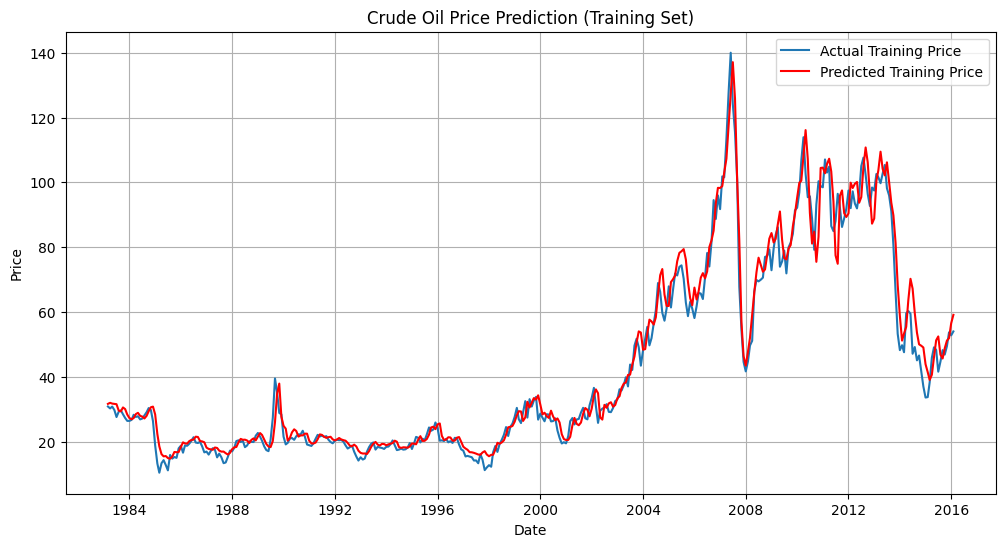

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


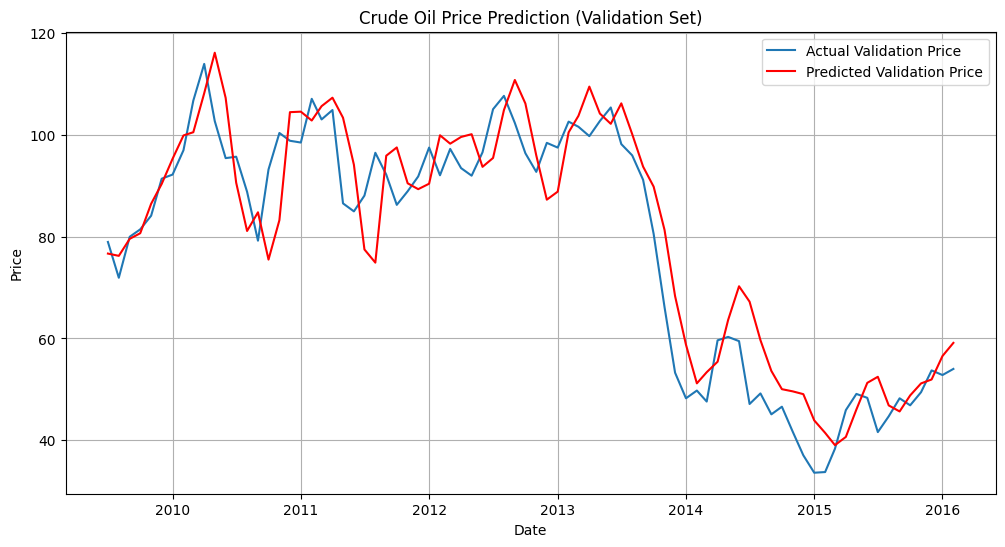

In [15]:
# Get the predictions for the training and validation sets
predicted_train_scaled = model.predict(X_train)

# Inverse transform the training predictions to get the actual prices
predicted_train_price = scaler.inverse_transform(predicted_train_scaled)

# Inverse transform the actual training prices
actual_train_price = scaler.inverse_transform(y_train)

# Get the dates for the training set
train_dates = df.index[:len(y_train)]

# Reshape the predicted and actual training prices to match the train_dates length
predicted_train_price_flat = predicted_train_price.flatten()
actual_train_price_flat = actual_train_price.flatten()

# Ensure the lengths match before plotting
if len(train_dates) > len(predicted_train_price_flat):
    train_dates = train_dates[:len(predicted_train_price_flat)]
elif len(train_dates) < len(predicted_train_price_flat):
     predicted_train_price_flat = predicted_train_price_flat[:len(train_dates)]
     actual_train_price_flat = actual_train_price_flat[:len(train_dates)]

# Plot the actual training data and the predicted training results
plt.figure(figsize=(12, 6))
plt.plot(train_dates, actual_train_price_flat, label='Actual Training Price')
plt.plot(train_dates, predicted_train_price_flat, label='Predicted Training Price', color='red')
plt.title('Crude Oil Price Prediction (Training Set)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Get the predictions for the validation set from the history object
validation_split_index = int(len(X_train) * 0.8)
X_val = X_train[validation_split_index:]
y_val = y_train[validation_split_index:]

predicted_val_scaled = model.predict(X_val)

# Inverse transform the validation predictions
predicted_val_price = scaler.inverse_transform(predicted_val_scaled)

# Inverse transform the actual validation prices
actual_val_price = scaler.inverse_transform(y_val)

# Get the dates for the validation set
val_dates = df.index[validation_split_index : validation_split_index + len(y_val)]

# Reshape the predicted and actual validation prices
predicted_val_price_flat = predicted_val_price.flatten()
actual_val_price_flat = actual_val_price.flatten()

# Ensure the lengths match before plotting
if len(val_dates) > len(predicted_val_price_flat):
    val_dates = val_dates[:len(predicted_val_price_flat)]
elif len(val_dates) < len(predicted_val_price_flat):
     predicted_val_price_flat = predicted_val_price_flat[:len(val_dates)]
     actual_val_price_flat = actual_val_price_flat[:len(val_dates)]


# Plot the actual validation data and the predicted validation results
plt.figure(figsize=(12, 6))
plt.plot(val_dates, actual_val_price_flat, label='Actual Validation Price')
plt.plot(val_dates, predicted_val_price_flat, label='Predicted Validation Price', color='red')
plt.title('Crude Oil Price Prediction (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 11. Final Training

In [16]:
# Append test data to training data
X_train_extended = np.concatenate((X_train, X_test), axis=0)
y_train_extended = np.concatenate((y_train, y_test), axis=0)

history_extended = model.fit(X_train_extended, y_train_extended, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

model.save('model.keras')

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0030 - val_loss: 0.0059
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0025 - val_loss: 0.0037
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0024 - val_loss: 0.0033
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - val_loss: 0.0035
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

#12. REAL APPLICATION: PREDICTION PRICE FOR 2026 AND BEYOND

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

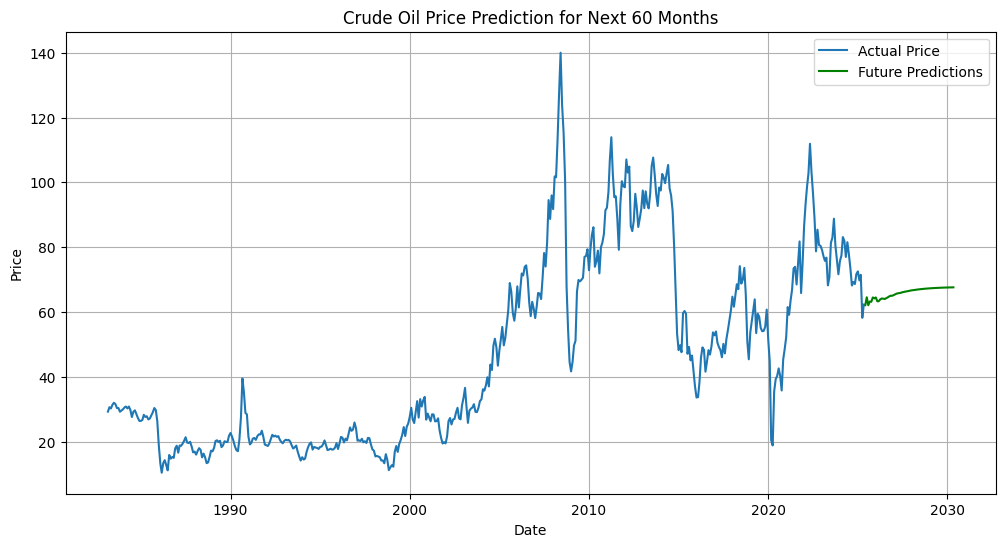

In [17]:
# prompt: now predict the next 36 months

# Function to predict future values
def predict_future(model, initial_sequence, num_steps, scaler, sequence_length):
    current_sequence = np.copy(initial_sequence)
    predicted_values_scaled = []

    for _ in range(num_steps):
        # Predict the next step(s)
        predicted_scaled = model.predict(current_sequence)
        predicted_values_scaled.append(predicted_scaled[0, 0]) # Assuming PREDICTION_STEPS is 1

        # Update the current sequence by removing the oldest value and adding the predicted value
        current_sequence = np.append(current_sequence[:, 1:, :], predicted_scaled.reshape(1, 1, 1), axis=1)

    # Inverse transform the predicted values
    predicted_values = scaler.inverse_transform(np.array(predicted_values_scaled).reshape(-1, 1))
    return predicted_values.flatten()

FUTURE_PREDICTION_MONTHS = 12*5 # 12*5

# Get the last sequence from the scaled data
last_sequence_scaled = data_scaled[-SEQUENCE_LENGTH:].reshape(1, SEQUENCE_LENGTH, 1)

# Predict the next months
future_predictions = predict_future(model, last_sequence_scaled, FUTURE_PREDICTION_MONTHS, scaler, SEQUENCE_LENGTH)

# Generate future dates for plotting
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date, periods=FUTURE_PREDICTION_MONTHS + 1, freq='MS')[1:]

# Plot the actual data and the future predictions
plt.figure(figsize=(12, 6))
plt.plot(df.index, df[VALUE_COL], label='Actual Price')
plt.plot(future_dates, future_predictions, label='Future Predictions', color='green')
plt.title(f'Crude Oil Price Prediction for Next {FUTURE_PREDICTION_MONTHS} Months')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

#12. A little Analyse

In [18]:
# Print the last actual price from the dataset
last_actual_price = df[VALUE_COL].iloc[-1]
print(f"Last Actual Price: {last_actual_price:.2f}")

# The last predicted price from the future predictions
last_predicted_price = future_predictions[-1]
print(f"Last Predicted Price: {last_predicted_price:.2f}")

# Calculate the percentage change between the last actual and last predicted prices
percentage_change = ((last_predicted_price - last_actual_price) / last_actual_price) * 100
print(f"Percentage Change: {percentage_change:.2f}%")

Last Actual Price: 62.29
Last Predicted Price: 67.61
Percentage Change: 8.54%
